In [1]:
import collections
import pathlib
import random
import os


import numpy as np
import pandas as pd
import scipy.stats
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import skimage
from skimage import exposure, img_as_float
#plt.style.use('dark_background')
#plt.style.use('seaborn-deep')
plt.style.use('Solarize_Light2')
%matplotlib inline

In [2]:
import importlib

In [3]:
import load_data

In [4]:
LABEL_NAMES = [
    "Nucleoplasm",
    "Nuclear membrane",
    "Nucleoli",
    "Nucleoli fibrillar center",
    "Nuclear speckles",
    "Nuclear bodies",
    "Endoplasmic reticulum",
    "Golgi apparatus",
    "Peroxisomes",
    "Endosomes",
    "Lysosomes",
    "Intermediate filaments",
    "Actin filaments",
    "Focal adhesion sites",
    "Microtubules",
    "Microtubule ends",
    "Cytokinetic bridge",
    "Mitotic spindle",
    "Microtubule organizing center",
    "Centrosome",
    "Lipid droplets",
    "Plasma membrane",
    "Cell junctions",
    "Mitochondria",
    "Aggresome",
    "Cytosol",
    "Cytoplasmic bodies",
    "Rods & rings",    
]

In [5]:
LABEL_NAMES_MAP = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

In [6]:
print(len(LABEL_NAMES))

28


In [7]:
INPUT_DIR = '../input/train'

In [8]:
importlib.reload(load_data)

<module 'load_data' from '/home/uldo/work/kaggle/competitions/Human_Protein_Atlas_Image_Classification/code/load_data.py'>

In [9]:
#load_data.os.listdir('.')

In [10]:
#print(load_data.show_data_dir_content('../input'))

In [11]:
train_df = load_data.load_text_data('../input/train.csv')

In [12]:
train_df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31072 entries, 0 to 31071
Data columns (total 2 columns):
Id        31072 non-null object
Target    31072 non-null object
dtypes: object(2)
memory usage: 485.6+ KB


In [14]:
train_df[train_df['Id'] == '00070df0-bbc3-11e8-b2bc-ac1f6b6435d0']

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0


In [15]:
print(train_df.shape)
print(type(train_df['Id'].unique()))
print((train_df['Id'].unique()).shape)
#train_df.set_index('Id')
train_df_id_idx = train_df.copy()
train_df_id_idx.set_index('Id', inplace=True)
#train_df_id_idx.head()
print(type(train_df_id_idx.loc['24297bee-bbb6-11e8-b2ba-ac1f6b6435d0']['Target']))

(31072, 2)
<class 'numpy.ndarray'>
(31072,)
<class 'str'>


In [16]:
def group_img_fnames(img_group_ids, img_suffixs, img_ext):
    return {
        img_grp_id: ['{}_{}.{}'.format(
                img_grp_id,
                img_suffix,
                img_ext
            )
        for img_suffix in img_suffixs] for img_grp_id in img_group_ids
    }

In [17]:
def load_imgs_color_groups(grouped_img_fnames):
    imgs_color_groups = {}
    for img_grp_id, img_fnames in grouped_img_fnames.items():
        grouped_images = {
            img_fname[:-4]: mpimg.imread(pathlib.Path(INPUT_DIR, img_fname).as_posix()) for img_fname in img_fnames
        }
        imgs_color_groups[img_grp_id] = grouped_images
    return imgs_color_groups

In [18]:
def show_images_grid(images_list, columns_num, figsize, images_names_list=None, colors=None, fontsize=20):
    rows_num = len(images_list) // columns_num
    fig, ax = plt.subplots(rows_num, columns_num, figsize=figsize)
    images_list_len = len(images_list)
    slice_len = columns_num
    images_list_slices_len = images_list_len // slice_len
    images_names_list_slices = []
    images_list_slices = [
        images_list[i * slice_len:(i+1) * slice_len]\
        for i in range(images_list_slices_len)
    ]
    if images_names_list:
        images_names_list_slices = [
            images_names_list[i * slice_len:(i+1) * slice_len]\
            for i in range(images_list_slices_len)
        ]
    #print("show_images_grid, images_names_list_slices:\n", images_names_list_slices)
    for i in range(ax.shape[0]):
        images_list_slice = images_list_slices[i]
        images_names_list_slice = []
        if images_names_list:
            images_names_list_slice = images_names_list_slices[i]
        #images_list_0 = [images_pair[0] for images_pair in paired_images_list_slice]
        #images_list_1 = [images_pair[1] for images_pair in paired_images_list_slice]
        for j in range(columns_num):
            if images_names_list:
                #print("show_images_grid, images_names_list_slice[{}]:\n".format(j), images_names_list_slice[j])
                ax[i, j].set_title(images_names_list_slice[j], fontsize=fontsize)
            if colors:
                ax[i, j].imshow(images_list_slice[j], cmap=colors[j])
            else:
                ax[i, j].imshow(images_list_slice[j])

            #ax[2 * i + 1, j].imshow(images_list_1[j])
            #plt.tick_params(axis='x', labelsize=fontsize)
            #plt.tick_params(axis='y', labelsize=fontsize)
    plt.tight_layout()
    plt.show()

In [19]:
def extract_targets_from_str_cell(targets_cell):
    return np.array(targets_cell.split(' ')).astype(np.int8)

In [20]:
def extract_targets(targets_column):
    #print("extract_targets, type(targets_colum): ", type(targets_column))
    #print("extract_targets, isinstance(targets_column, np.ndarray): ", isinstance(targets_column, np.ndarray))
    if isinstance(targets_column, str):
        return extract_targets_from_str_cell(targets_column)
    elif not isinstance(targets_column, np.ndarray):
        #print("extract_targets, not isinstance if branch")
        return targets_column.apply(extract_targets_from_str_cell)
    else:
        return targets_column

In [21]:
def fill_targets(df_row, targets_column_name='Target'):
    df_row[targets_column_name] = np.array(df_row[targets_column_name].split(' ')).astype(np.int8)
    for label_name in LABEL_NAMES:
        df_row[label_name] = 0
    for num in df_row[targets_column_name]:
        df_row[LABEL_NAMES[int(num)]] = 1
    return df_row

In [22]:
def get_label_freqs(targets_column, label_names, ascending=None):
    classes_num = len(label_names)
    freqs = np.array([0] * classes_num)
    for targets_num_lst in targets_column:
        for class_idx in range(classes_num):
            freqs[class_idx] += class_idx in targets_num_lst
    data = {
        'name': label_names,
        'frequency': freqs,
        'percent': (10000 * freqs / len(targets_column)).astype(int) / 100.
    }
    columns = ['name', 'frequency', 'percent']
    label_frequency_df = pd.DataFrame(data, columns=columns)
    if ascending is not None:
        label_frequency_df = label_frequency_df.sort_values(by='frequency', ascending=ascending)
    return label_frequency_df

In [23]:
def get_image_labels(image_id, label_names, images_description_df):
    image_labels_lst = [
        str(label_names[label_idx]) for label_idx in extract_targets(
            images_description_df.loc[image_id]['Target']
            #images_description_df[images_description_df['Id'] == image_id]['Target']
        )
    ]
    return ', '.join(image_labels_lst)

In [24]:
def create_image_names_list(image_ids, label_names, images_description_df, category_names):
    images_description_df_id_idx = train_df.copy()
    images_description_df_id_idx.set_index('Id', inplace=True)
    image_names_list = []
    for image_id in image_ids:
        image_names_list.append(get_image_labels(image_id, label_names, images_description_df_id_idx))
        image_names_list.extend(category_names)
    return image_names_list

In [25]:
def find_counts(special_target, labels):
    counts = labels[labels[special_target] == 1].drop(['Id', 'Target', 'number_of_targets'], axis=1).sum(axis=0)
    counts = counts[counts > 0]
    return counts.sort_values()

In [26]:
#train_df['Id'].tolist()[:20]

In [27]:
#img_fnames = group_img_fnames(train_df['Id'].tolist()[:20], ('blue', 'green', 'red', 'yellow'), 'png')

In [28]:
#load_data.os.listdir('../input/')[:20]

In [29]:
#print(img_fnames)

In [30]:
sel_img_ids = load_data.random_objects_select(train_df['Id'], 4000)

In [31]:
grouped_img_fnames = group_img_fnames(sel_img_ids, ('blue', 'green', 'red', 'yellow'), 'png')

In [32]:
print(len(grouped_img_fnames))

4000


In [33]:
imgs_color_groups = load_imgs_color_groups(grouped_img_fnames)

In [34]:
first_20_ids = tuple(imgs_color_groups.keys())[:20]
first_img_id = first_20_ids[0]
print(tuple(imgs_color_groups.keys())[:20])

('b7eea76c-bba4-11e8-b2ba-ac1f6b6435d0', 'd8f50874-bbaf-11e8-b2ba-ac1f6b6435d0', '2e424322-bbb6-11e8-b2ba-ac1f6b6435d0', '55955926-bbb8-11e8-b2ba-ac1f6b6435d0', '4618c382-bbba-11e8-b2ba-ac1f6b6435d0', '5a49c110-bb9e-11e8-b2b9-ac1f6b6435d0', '8429f0b4-bbbb-11e8-b2ba-ac1f6b6435d0', '3b56f79c-bbac-11e8-b2ba-ac1f6b6435d0', 'aca44a3c-bbb4-11e8-b2ba-ac1f6b6435d0', 'ac007074-bbb9-11e8-b2ba-ac1f6b6435d0', '898f12c2-bbb2-11e8-b2ba-ac1f6b6435d0', '709f2cce-bbbd-11e8-b2ba-ac1f6b6435d0', '88fcc8c4-bbc9-11e8-b2bc-ac1f6b6435d0', '41a0b352-bba9-11e8-b2ba-ac1f6b6435d0', '4e5cfeba-bba5-11e8-b2ba-ac1f6b6435d0', 'ad314832-bbc4-11e8-b2bc-ac1f6b6435d0', '6b421882-bba8-11e8-b2ba-ac1f6b6435d0', 'fad1868a-bbc2-11e8-b2bc-ac1f6b6435d0', '2b7e0e6a-bbab-11e8-b2ba-ac1f6b6435d0', 'eef76f56-bb99-11e8-b2b9-ac1f6b6435d0')


In [35]:
first_img_group = imgs_color_groups[first_img_id]

In [36]:
first_blue_channel = first_img_group['{}_blue'.format(first_img_id)]

In [37]:
print(type(first_blue_channel))
print(first_blue_channel.shape)

<class 'numpy.ndarray'>
(512, 512)


In [38]:
train_df.describe()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31072 entries, 0 to 31071
Data columns (total 2 columns):
Id        31072 non-null object
Target    31072 non-null object
dtypes: object(2)
memory usage: 485.6+ KB


In [39]:
train_df['Id'].dtype
train_df['Target'].dtype
print(train_df.columns)
isinstance(train_df['Target'], np.ndarray)

Index(['Id', 'Target'], dtype='object')


False

In [40]:
imgs_list = []
for img_grp_id in first_20_ids:
    imgs_list.extend(imgs_color_groups[img_grp_id].values())

In [41]:
train_df_id_idx = train_df.copy()
train_df_id_idx.set_index('Id', inplace=True)
img0_labels = get_image_labels('00070df0-bbc3-11e8-b2bc-ac1f6b6435d0', LABEL_NAMES, train_df_id_idx)
print(img0_labels)
print(train_df_id_idx.loc['d97a3cdc-bbb5-11e8-b2ba-ac1f6b6435d0'])

Cytokinetic bridge, Nucleoplasm
Target    7
Name: d97a3cdc-bbb5-11e8-b2ba-ac1f6b6435d0, dtype: object


In [42]:
image_names_list = create_image_names_list(first_20_ids[:2], LABEL_NAMES, train_df, ('Microtubules', 'Nucleus', 'Endoplasmatic reticulum'))

In [43]:
image_names_list

['Nucleoli',
 'Microtubules',
 'Nucleus',
 'Endoplasmatic reticulum',
 'Cytokinetic bridge, Microtubules, Mitotic spindle',
 'Microtubules',
 'Nucleus',
 'Endoplasmatic reticulum']

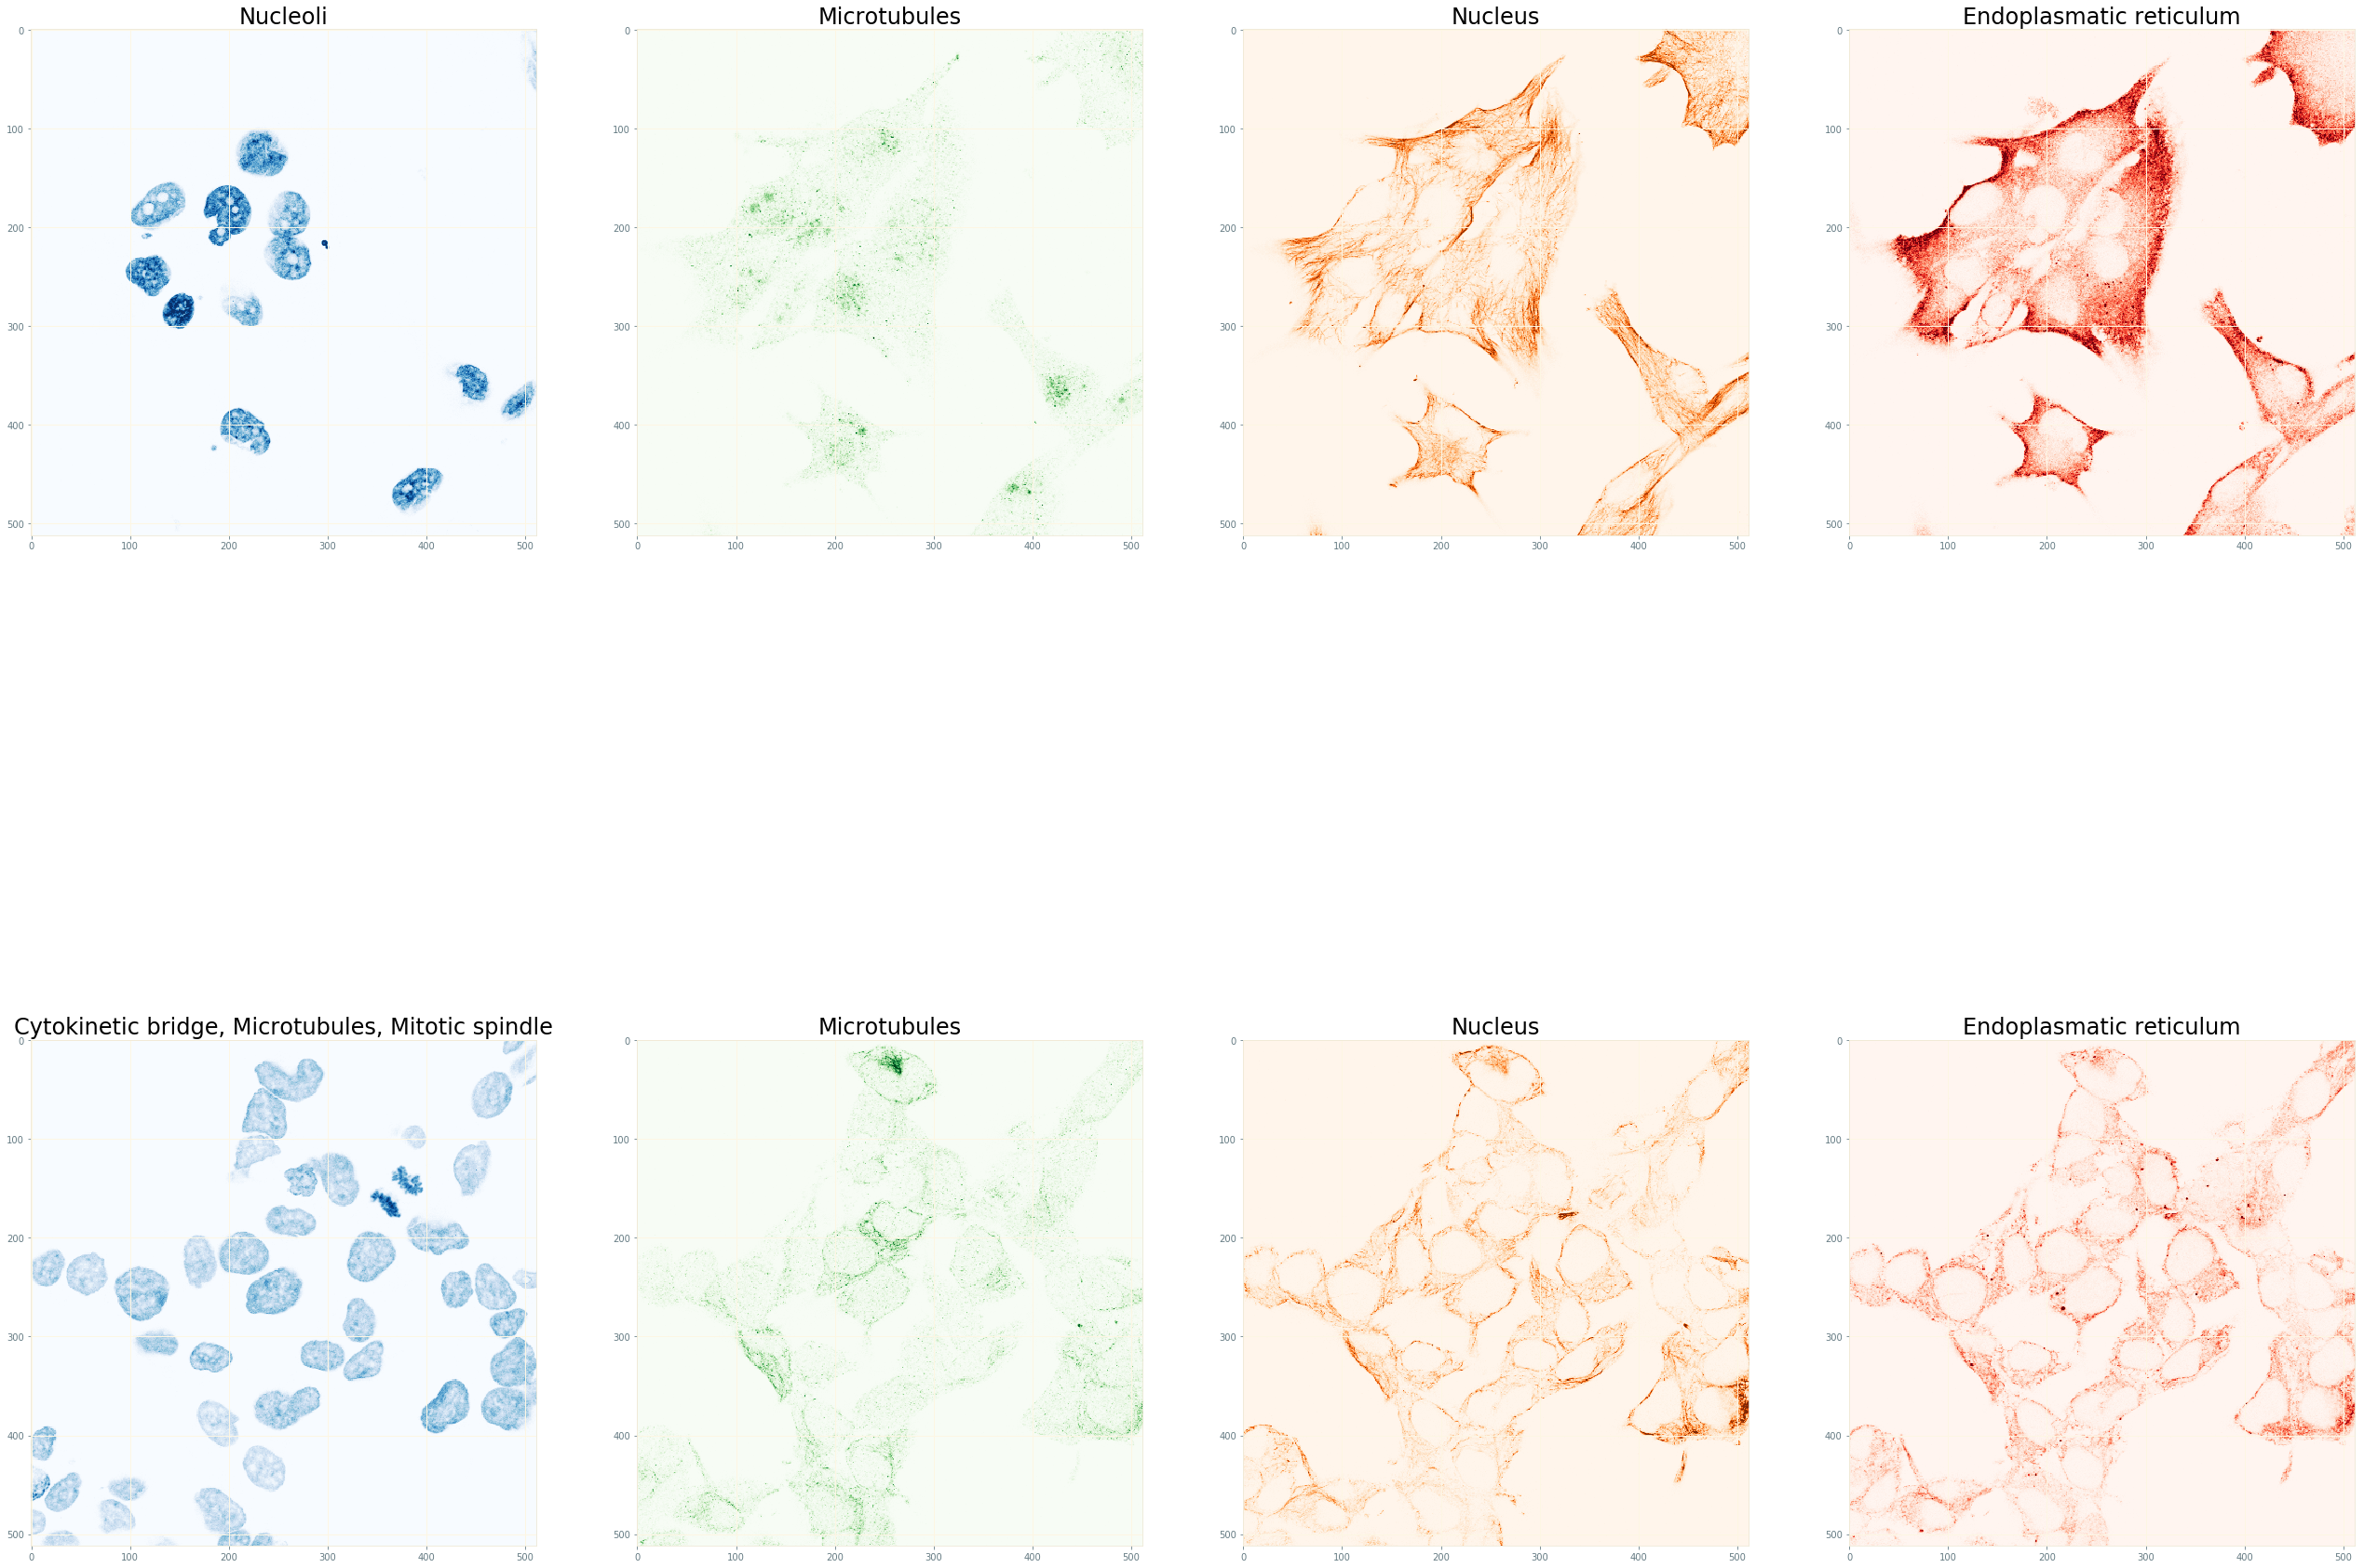

In [44]:
show_images_grid(
    imgs_list[:8],
    4,
    (36, 36),
    images_names_list=image_names_list,
    colors=('Blues', 'Greens', 'Oranges', 'Reds'),
    fontsize=24
)

In [45]:
#targets = extract_targets(train_df.loc[0]['Target'])

In [46]:
#print(targets)
#print(train_df['Target'].head())

In [47]:
train_targets = extract_targets(train_df['Target'])

In [48]:
print(type(train_targets))
print(type(train_targets.loc[0]))

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


In [49]:
print(train_targets.head())

0         [16, 0]
1    [7, 1, 2, 0]
2             [5]
3             [1]
4            [18]
Name: Target, dtype: object


In [50]:
train_df = train_df.apply(fill_targets, axis=1)

In [51]:
train_df.head()

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,"[16, 0]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,"[7, 1, 2, 0]",1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,[5],0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,[1],0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,[18],0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [52]:
train_frequencies_df = get_label_freqs(train_targets, LABEL_NAMES, ascending=False)

In [53]:
print(train_frequencies_df)

                             name  frequency  percent
0                     Nucleoplasm      12885    41.46
25                        Cytosol       8228    26.48
21                Plasma membrane       3777    12.15
2                        Nucleoli       3621    11.65
23                   Mitochondria       2965     9.54
7                 Golgi apparatus       2822     9.08
5                  Nuclear bodies       2513     8.08
4                Nuclear speckles       1858     5.97
3       Nucleoli fibrillar center       1561     5.02
19                     Centrosome       1482     4.76
1                Nuclear membrane       1254     4.03
11         Intermediate filaments       1093     3.51
14                   Microtubules       1066     3.43
6           Endoplasmic reticulum       1008     3.24
18  Microtubule organizing center        902     2.90
22                 Cell junctions        802     2.58
12                Actin filaments        688     2.21
13           Focal adhesion 

Text(0,0.5,'Frequency')

<Figure size 432x288 with 0 Axes>

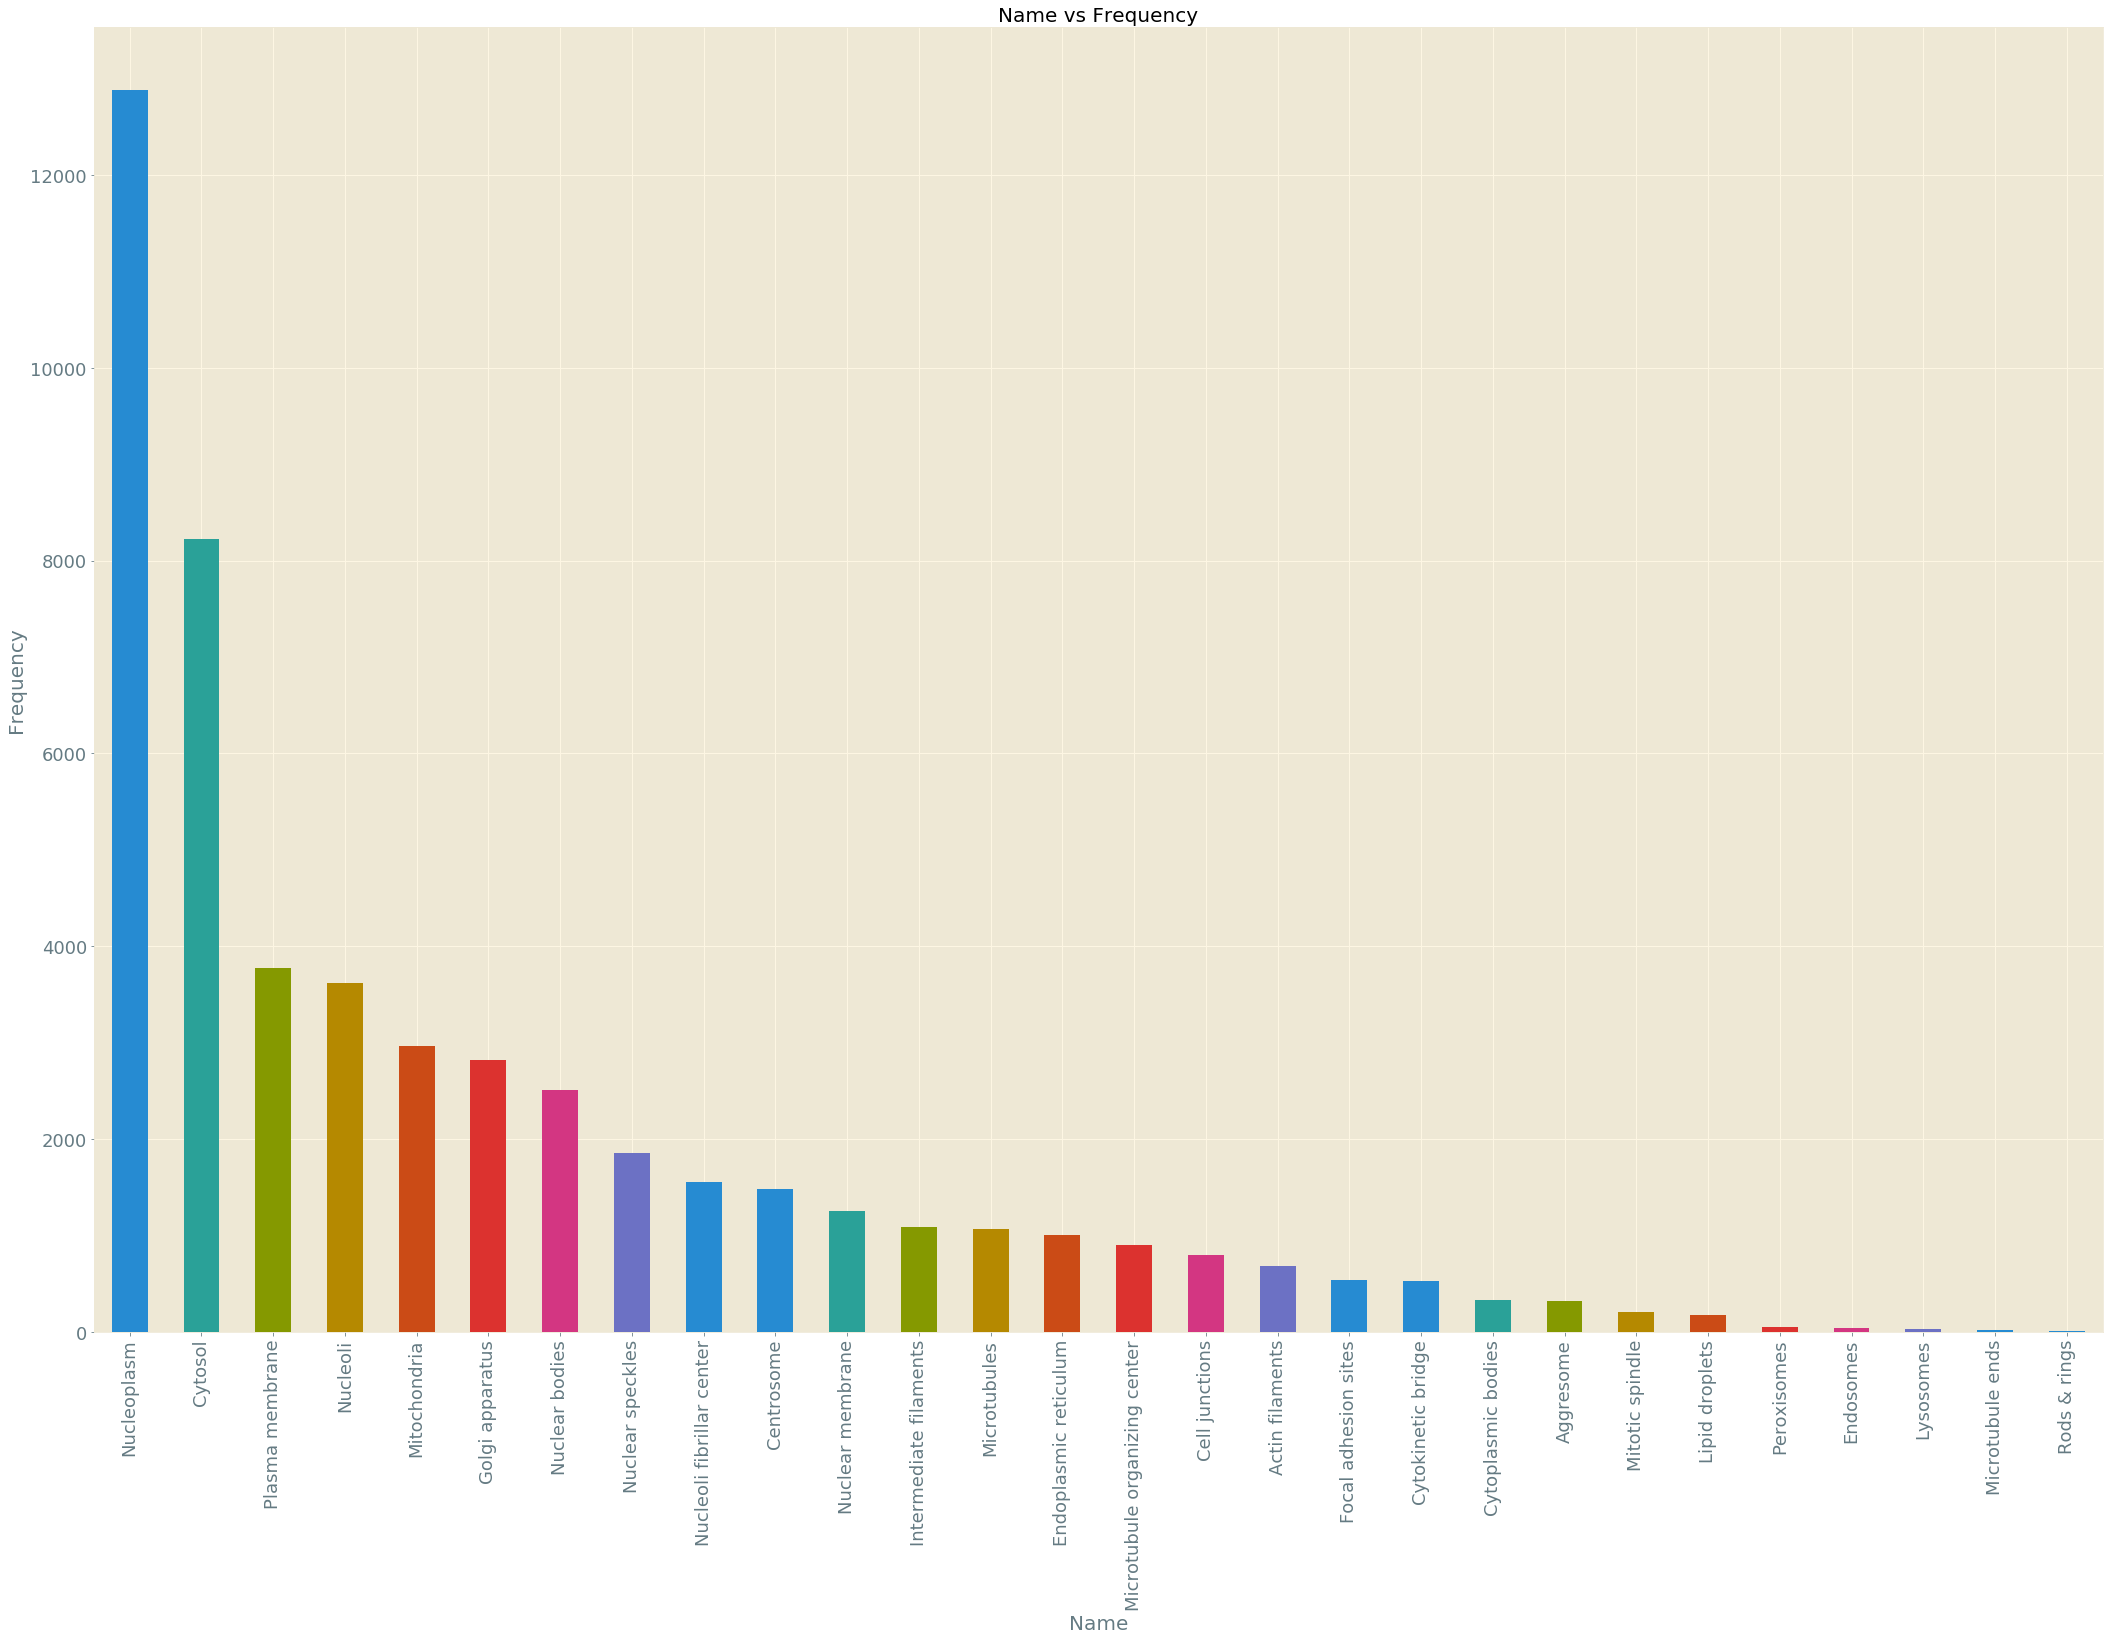

In [54]:
fig = plt.figure()
#train_frequencies_df.plot(x='name', y='frequency', kind='bar', title="Name vs Frequency", figsize=(36, 24))
ax = train_frequencies_df.plot(x='name', y='frequency', kind='bar', figsize=(36, 24), legend=False)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.title("Name vs Frequency", fontsize=20)
#ax.tick_params(axis='x', labelsize=18)
#ax.tick_params(axis='y', labelsize=18)
#ax.title("Name vs Frequency", fontsize=20)
ax.set_xlabel("Name", fontsize=20)
ax.set_ylabel("Frequency", fontsize=20)

Text(0,0.5,'Frequency')

<Figure size 432x288 with 0 Axes>

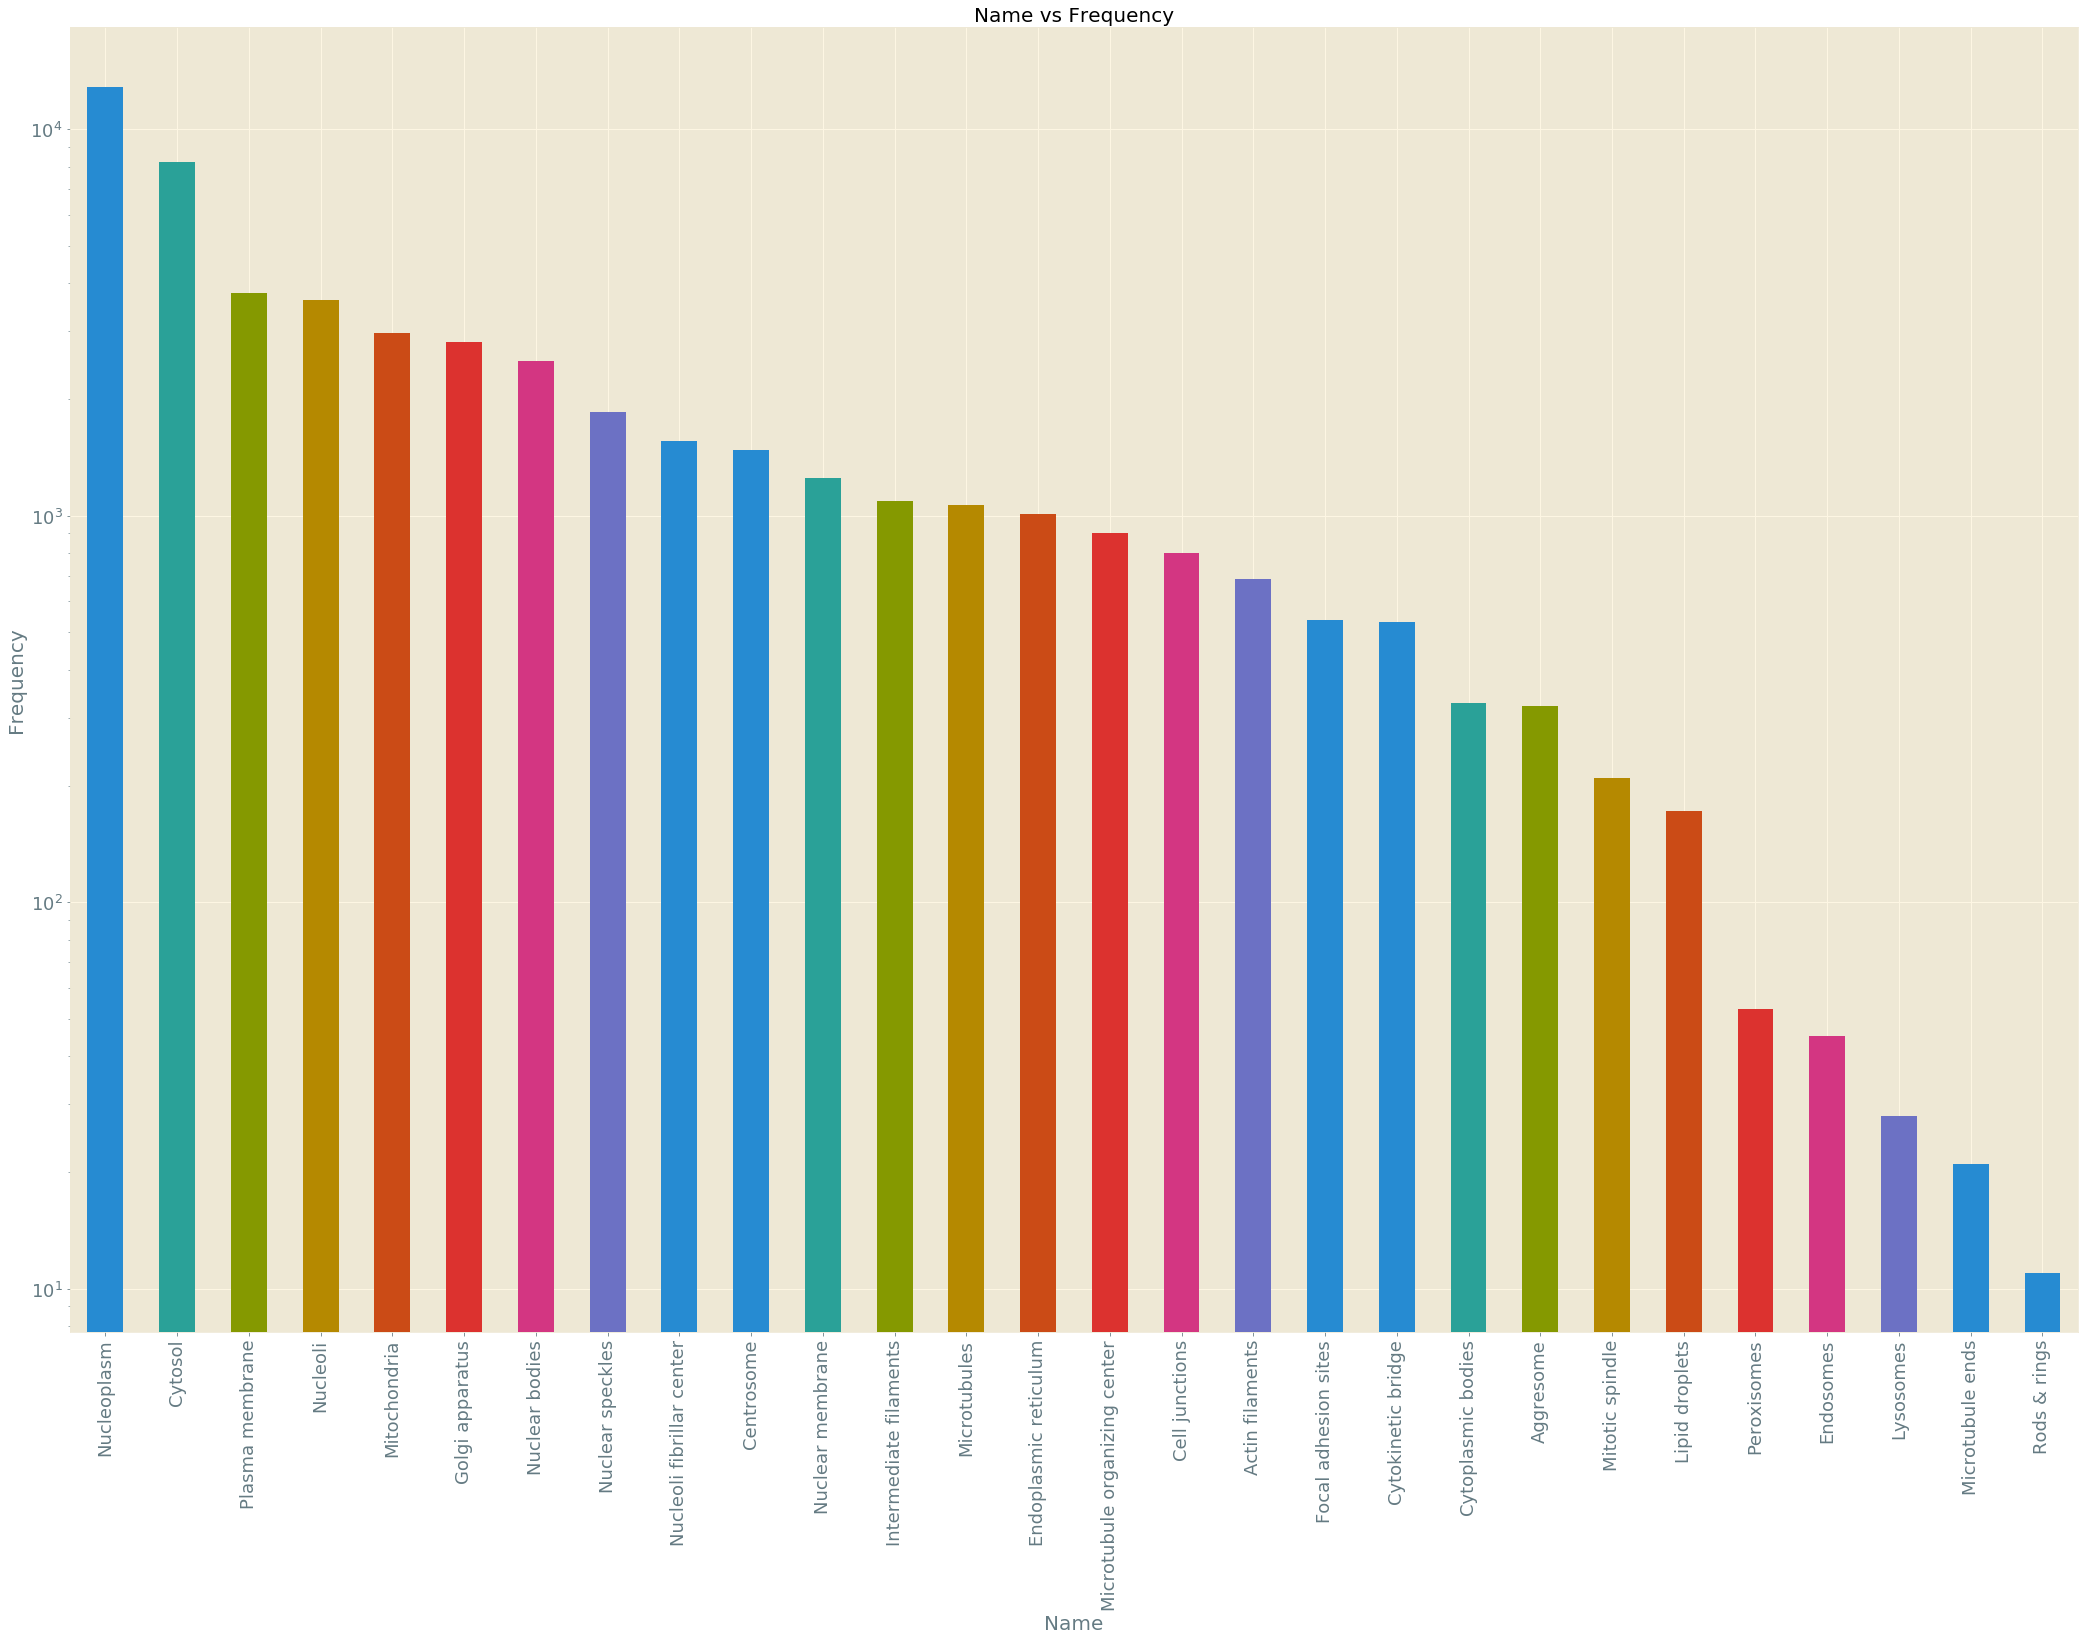

In [55]:
fig = plt.figure()
#train_frequencies_df.plot(x='name', y='frequency', kind='bar', title="Name vs Frequency", figsize=(36, 24))
ax = train_frequencies_df.plot(x='name', y='frequency', logy=True, kind='bar', figsize=(36, 24), legend=False)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.title("Name vs Frequency", fontsize=20)
#ax.tick_params(axis='x', labelsize=18)
#ax.tick_params(axis='y', labelsize=18)
#ax.title("Name vs Frequency", fontsize=20)
ax.set_xlabel("Name", fontsize=20)
ax.set_ylabel("Frequency", fontsize=20)

In [56]:
train_df_exp_copy = train_df.copy()

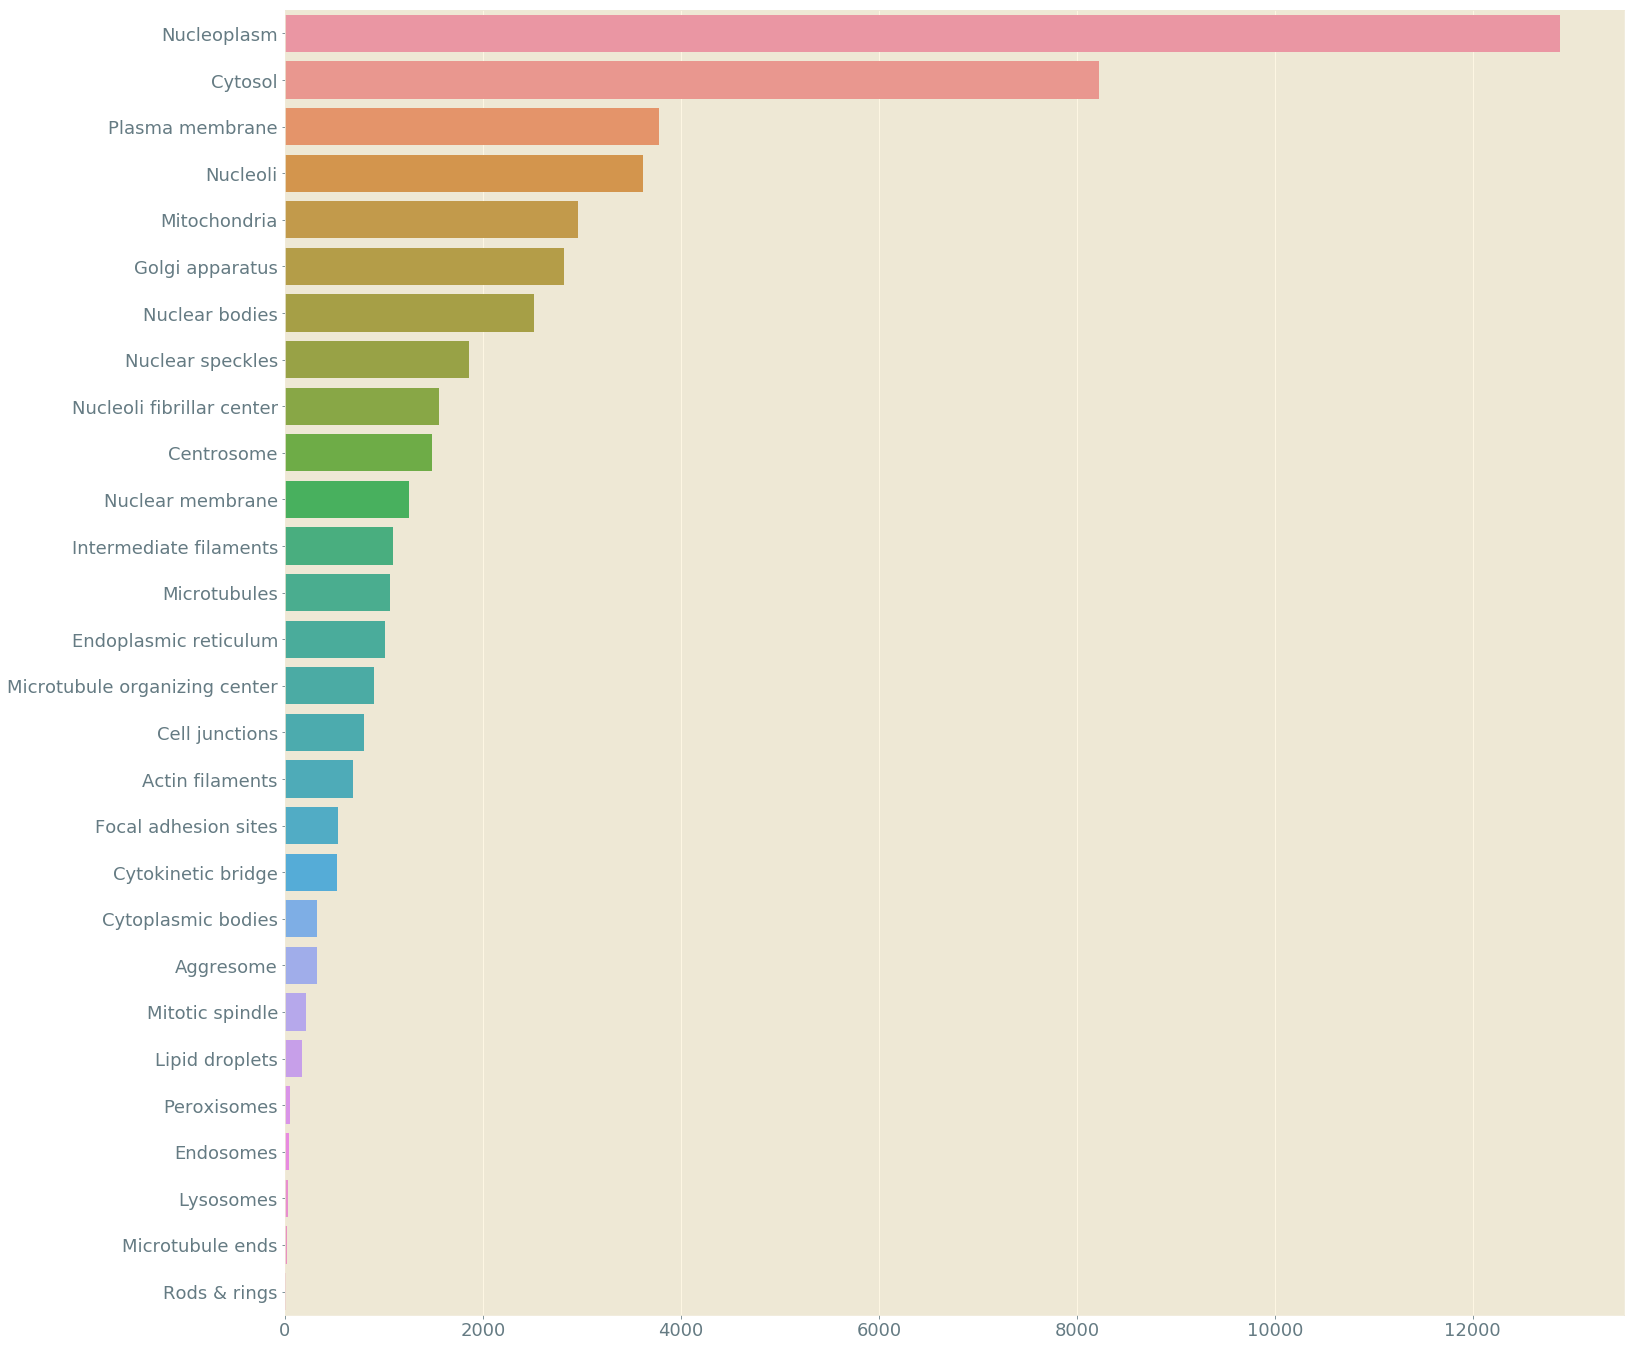

In [57]:
target_counts = train_df_exp_copy.drop(['Id', 'Target'], axis=1).sum(axis=0).sort_values(ascending=False)
plt.figure(figsize=(24, 24))
sns.barplot(y=target_counts.index.values, x=target_counts.values, order=target_counts.index)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

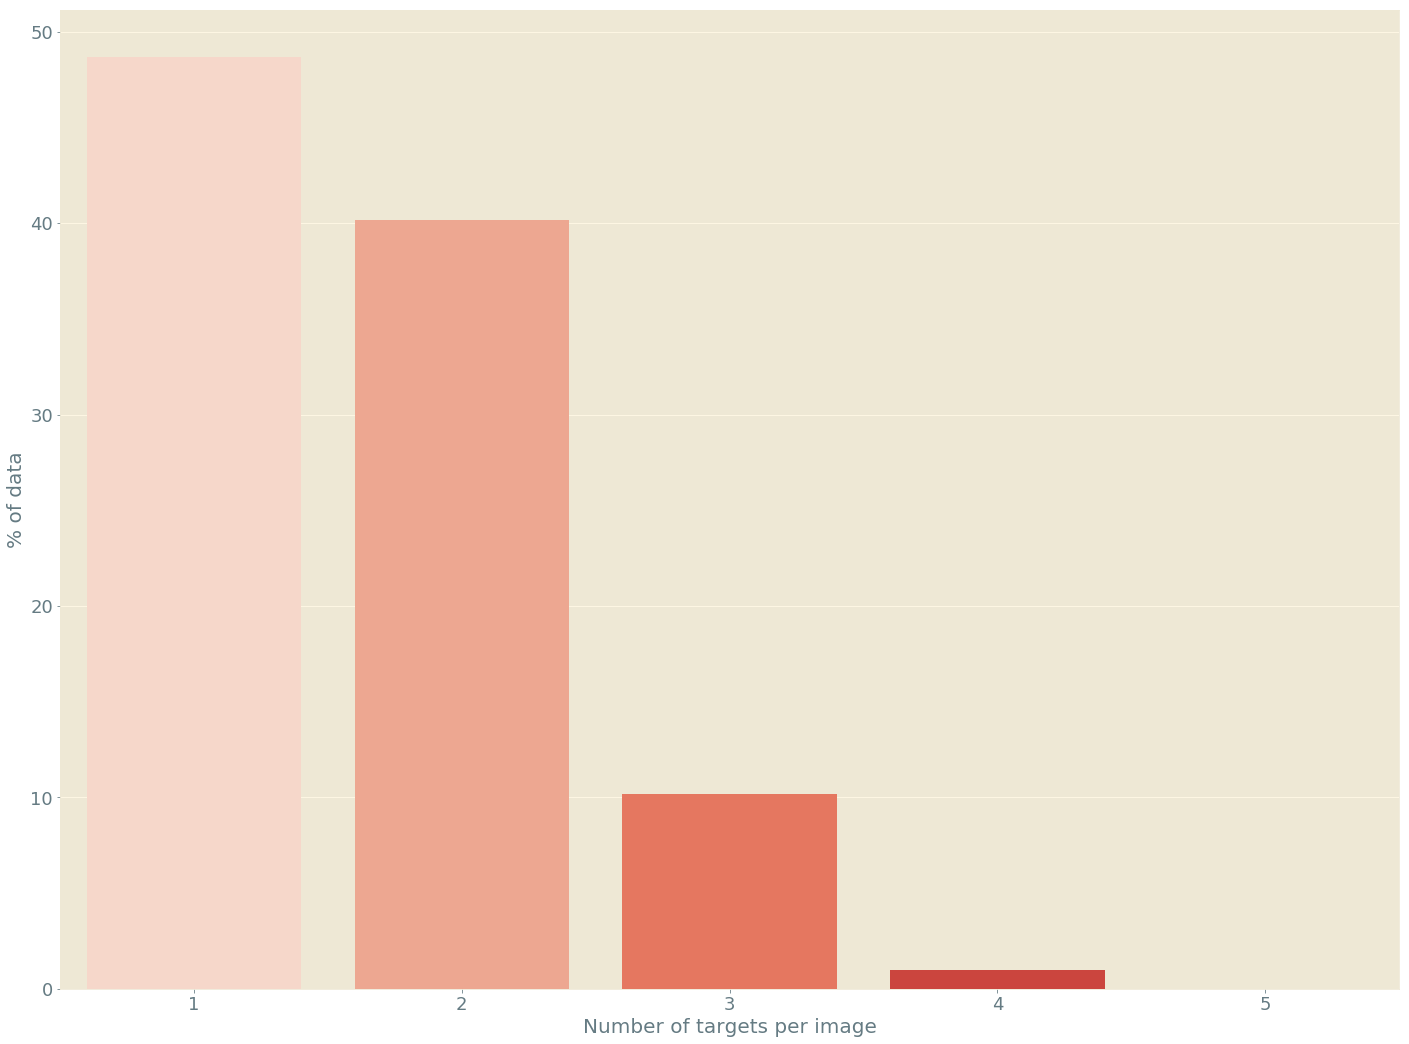

In [58]:
train_df_exp_copy['number_of_targets'] = train_df_exp_copy.drop(['Id', 'Target'], axis=1).sum(axis=1)
count_perc = np.round(
    100 * train_df_exp_copy['number_of_targets'].value_counts() / train_df_exp_copy.shape[0],
    2
)
plt.figure(figsize=(24, 18))
barplot = sns.barplot(x=count_perc.index.values, y=count_perc.values, palette='Reds')
barplot.set_xlabel("Number of targets per image", fontsize=20)
barplot.set_ylabel("% of data", fontsize=20)
barplot.tick_params(labelsize=18)
#plt.tick_params(axis='x', labelsize=18)
#plt.tick_params(axis='y', labelsize=18)
#plt.xlabel("Number of targets per image")
#plt.ylabel("% of data")

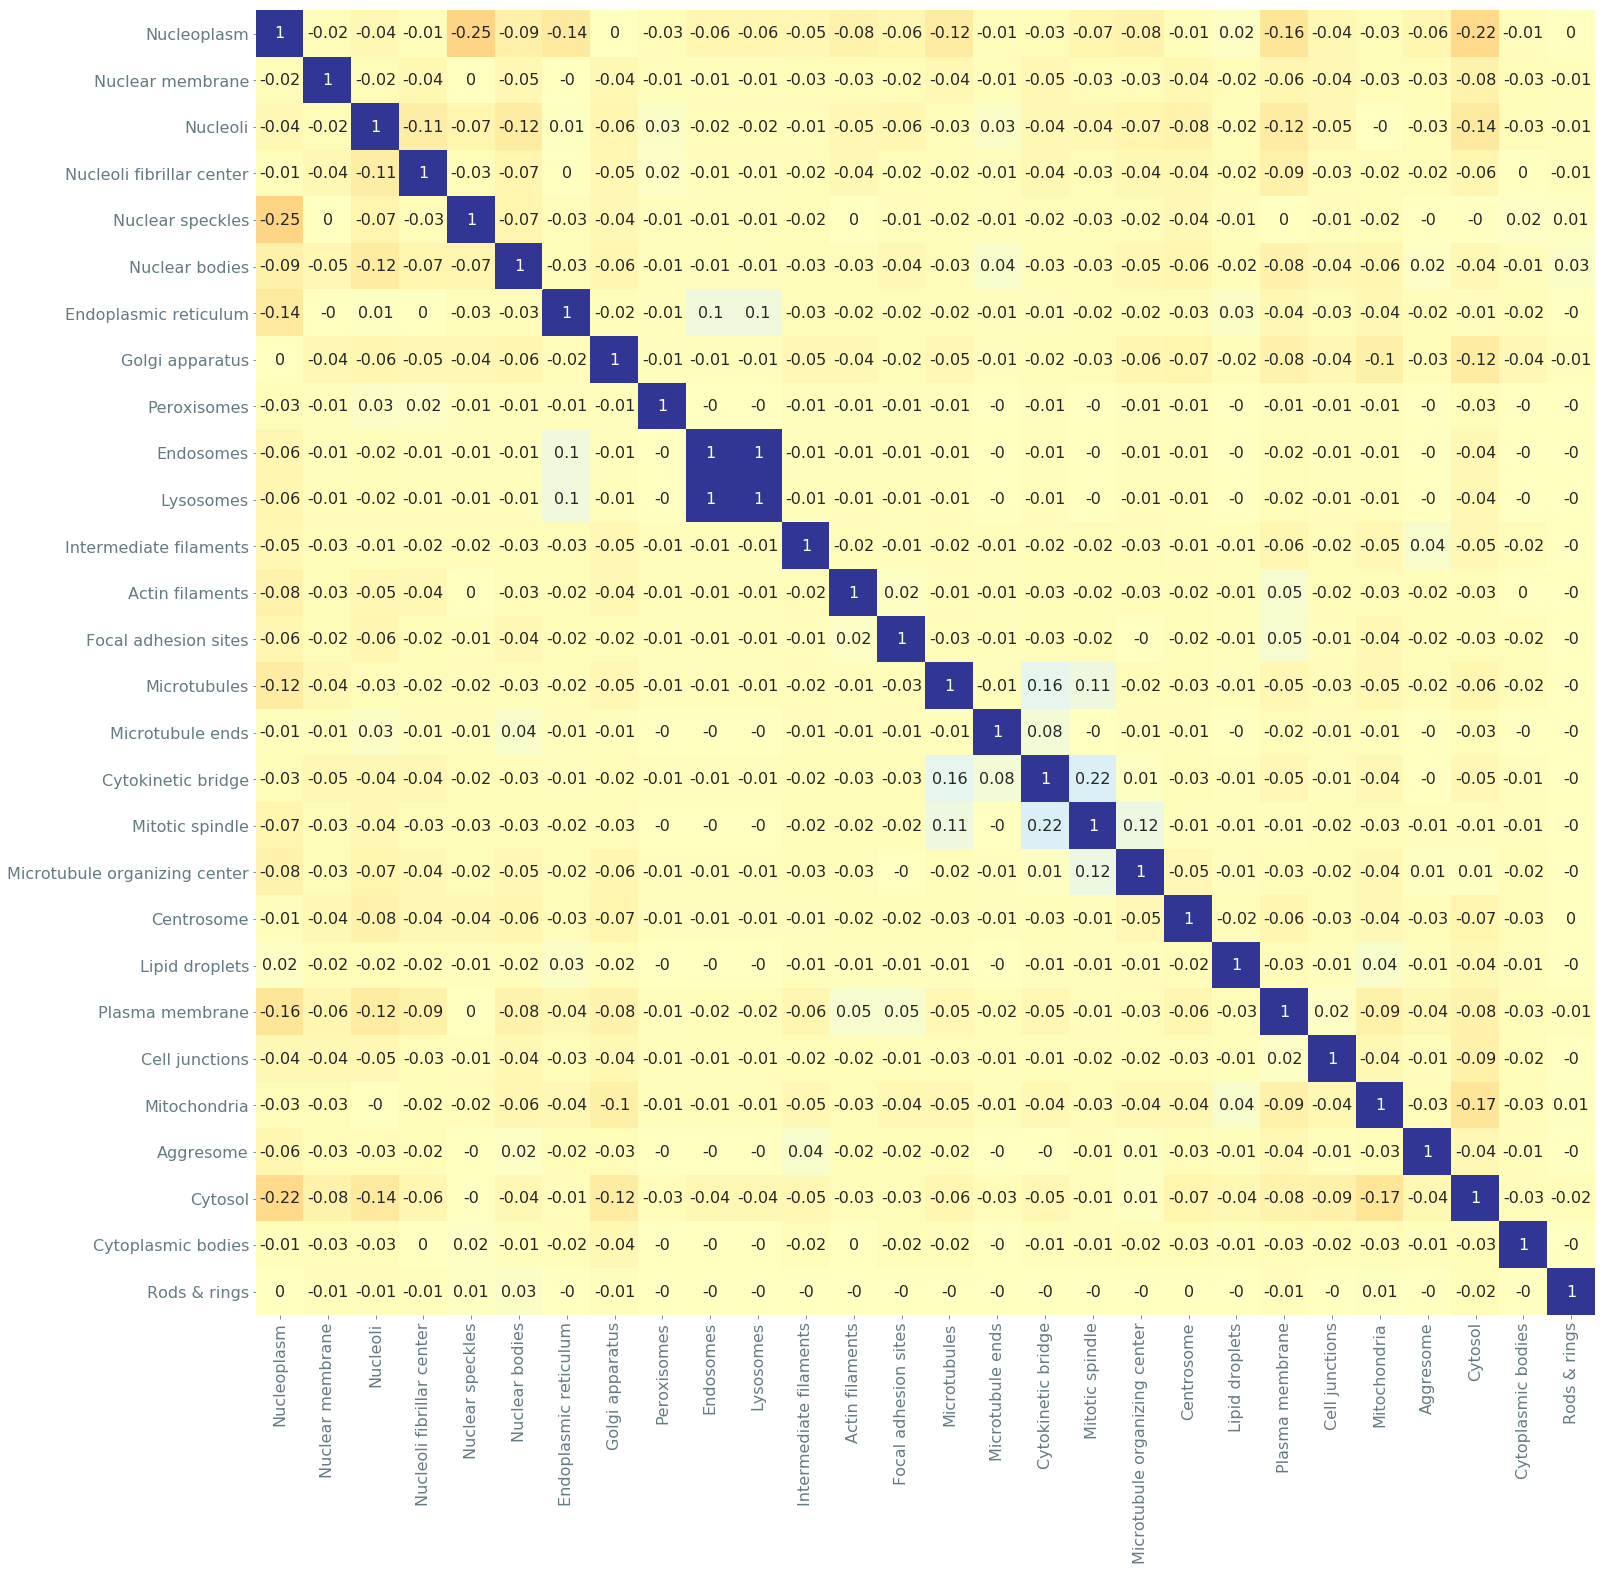

In [59]:
#plt.figure(figsize=(24, 24))
#heatmap_fig = sns.heatmap(
#    scaled_with_dropped_regions_hier_concantenated_df.corr().round(2),
#    annot=True, annot_kws={"size":24},
#    cbar=False
#)
#for item in heatmap_fig.get_xticklabels():
#    item.set_fontsize(24)
#for item in heatmap_fig.get_yticklabels():
#    item.set_fontsize(24)
#for item in heatmap_fig.get_label():
#    item.set_fontsize(24)
plt.figure(figsize=(24, 24))
heatmap = sns.heatmap(
    train_df_exp_copy[train_df_exp_copy['number_of_targets'] > 1].drop(
        ['Id', 'Target', 'number_of_targets'], axis=1).corr().round(2),
    annot=True,
    annot_kws={'size': 16},
    cbar=False,
    cmap='RdYlBu',
    vmin=-1,
    vmax=1
)
    
#barplot.set_xlabel("Number of targets per image", fontsize=20)
#barplot.set_ylabel("% of data", fontsize=20)
heatmap.tick_params(labelsize=16)

In [60]:
lyso_endo_counts = find_counts('Lysosomes', train_df_exp_copy)

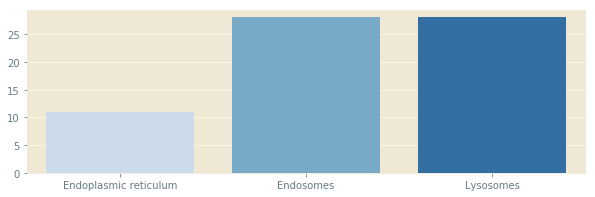

In [61]:
plt.figure(figsize=(10, 3))
sns.barplot(x=lyso_endo_counts.index.values, y=lyso_endo_counts.values, palette='Blues')

In [62]:
rod_ring_counts = find_counts('Rods & rings', train_df_exp_copy)

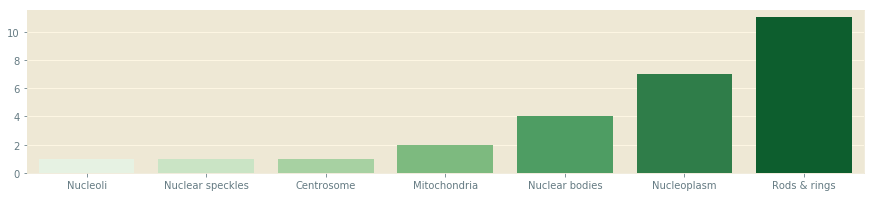

In [63]:
plt.figure(figsize=(15, 3))
sns.barplot(x=rod_ring_counts.index.values, y=rod_ring_counts.values, palette='Greens')

In [64]:
peroxi_counts = find_counts('Peroxisomes', train_df_exp_copy)

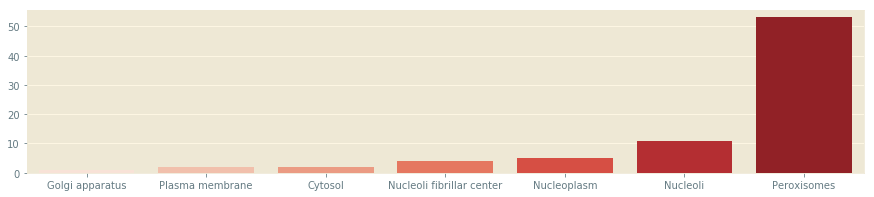

In [65]:
plt.figure(figsize=(15, 3))
sns.barplot(x=peroxi_counts.index.values, y=peroxi_counts.values, palette='Reds')

In [66]:
tubeends_counts = find_counts('Microtubule ends', train_df_exp_copy)

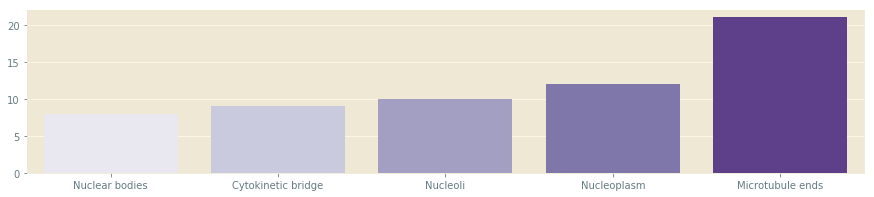

In [67]:
plt.figure(figsize=(15, 3))
sns.barplot(x=tubeends_counts.index.values, y=tubeends_counts.values, palette='Purples')

In [68]:
nuclear_speckles_counts = find_counts('Nuclear speckles', train_df_exp_copy)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]), <a list of 23 Text xticklabel objects>)

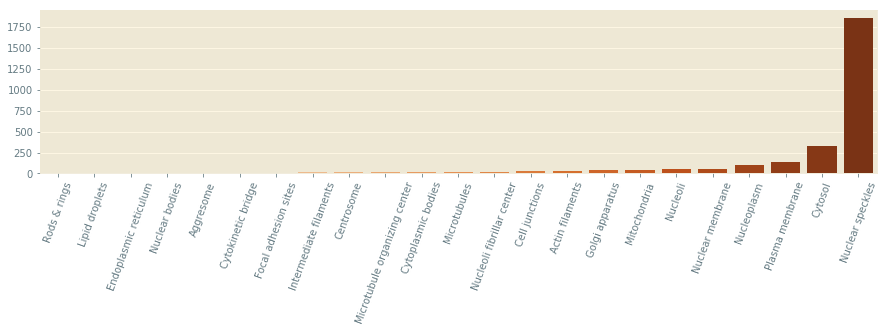

In [69]:
plt.figure(figsize=(15, 3))
sns.barplot(x=nuclear_speckles_counts.index.values, y=nuclear_speckles_counts.values, palette='Oranges')
plt.xticks(rotation='70')

In [70]:
targets = train_df['Target'].value_counts().keys()
print(targets)

Index([        [0],        [23],        [25],         [7],         [4],
              [21],         [5],         [2],         [3],         [6],
       ...
           [23, 0],     [0, 21],  [25, 3, 0], [25, 0, 21],      [1, 0],
           [23, 0],     [24, 5],      [7, 0],      [3, 0],    [26, 25]],
      dtype='object', length=15971)


In [72]:
classes = np.arange(0, 28)
multilabel_binarizer = MultiLabelBinarizer(classes)
multilabel_binarizer.fit(classes)
binarized_targets = multilabel_binarizer.transform([tuple(targets)])
print(binarized_targets)

TypeError: unhashable type: 'numpy.ndarray'